In [128]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (MONTHLY, MonthLocator, DateFormatter,
                              rrulewrapper, RRuleLocator)
from sklearn.cluster import KMeans

import rasterio
from rasterio.crs import CRS
import rioxarray as rxr
import earthpy as et
import geemap
import ee

In [ ]:
# importing fires dataset 
fire_dataset = "/home/sherwood/learning/Data4Policy/Geospatial Data Science Internship/Datasets/telangana_fires.csv"

df_fires = pd.read_csv(fire_dataset, index_col='acq_date', parse_dates=True)

# extracting date of fire
acq_date = pd.read_csv(fire_dataset)
acq_date = np.array(acq_date.acq_date,dtype='datetime64')

# # getting the labels of each fire point
fire_types = pd.read_csv(fire_dataset, index_col='acq_date', parse_dates=True,usecols=['confidence','type','acq_date'])
fire_types = fire_types[fire_types.confidence >= 30]

# subsetting columns
df_fires = df_fires[['latitude','longitude','confidence','brightness','bright_t31','frp']]
df_fires['acq_date'] = acq_date
df_fires['confidence'].astype(int)

In [110]:
df_fires.head()

,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date
acq_date,,,,,,,
2015-01-02,18.3777,80.5314,69,318.6,302.6,7.7,2015-01-02
2015-01-04,17.5898,80.9893,59,315.4,299.5,8.8,2015-01-04
2015-01-05,17.6028,81.1612,46,311.8,299.8,6.0,2015-01-05
2015-01-05,17.5241,80.3135,69,317.0,302.0,9.3,2015-01-05
2015-01-05,17.7571,80.3404,53,317.2,300.0,29.3,2015-01-05


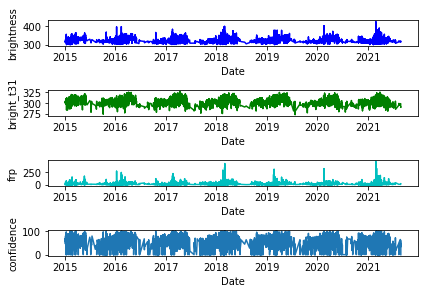

In [113]:
fig , (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1)
fig.subplots_adjust(hspace=1)

t = df_fires.acq_date
confidence = df_fires.confidence
brightness = df_fires.brightness
bright_t31 = df_fires.bright_t31
frp = df_fires.frp

ax1.plot(t,brightness,'b')
ax1.set_xlabel('Date')
ax1.set_ylabel('brightness')

ax2.plot(t,bright_t31,'g')
ax2.set_xlabel('Date')
ax2.set_ylabel('bright_t31')

ax3.plot(t,frp,'c')
ax3.set_xlabel('Date')
ax3.set_ylabel('frp')

ax4.plot(t,confidence)
ax4.set_xlabel('Date')
ax4.set_ylabel('confidence')

# df_fires['frp'].plot(ax=axes[0])
# df_fires['brightness'].plot(ax=axes[1])
# df_fires['bright_t31'].plot(ax=axes[2])

plt.tight_layout()
plt.show()

In [169]:
# making subsetting given confidence >30
df_fires = df_fires[df_fires.confidence>=30]


df_fires

,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date
acq_date,,,,,,,
2015-01-02,18.3777,80.5314,69,318.6,302.6,7.7,2015-01-02
2015-01-04,17.5898,80.9893,59,315.4,299.5,8.8,2015-01-04
2015-01-05,17.6028,81.1612,46,311.8,299.8,6.0,2015-01-05
2015-01-05,17.5241,80.3135,69,317.0,302.0,9.3,2015-01-05
2015-01-05,17.7571,80.3404,53,317.2,300.0,29.3,2015-01-05
...,...,...,...,...,...,...,...
2021-08-24,18.5503,77.7573,38,318.1,298.3,8.3,2021-08-24
2021-08-24,18.3923,77.8257,61,315.4,298.3,7.2,2021-08-24
2021-08-24,18.4943,77.7611,37,317.2,298.6,8.2,2021-08-24


In [118]:
monthly_fires = df_fires[['frp']].resample(rule='M').count()


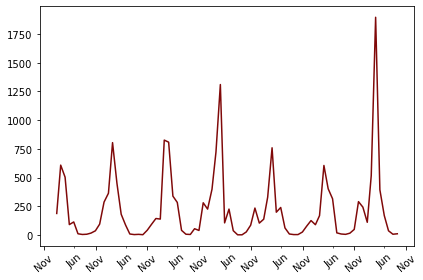

In [119]:
dates = monthly_fires.index

fig , ax = plt.subplots()
plt.plot(dates,monthly_fires.frp,'#800909')
ax.xaxis.set_major_locator(MonthLocator(bymonth=11))
ax.xaxis.set_minor_locator(MonthLocator(bymonth=6))
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.xaxis.set_minor_formatter(DateFormatter('%b'))

ax.xaxis.set_tick_params(rotation = 40, labelsize = 10)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=40)

plt.tight_layout()

plt.show()

This graph suggests months should also be taken into account 

In [120]:
df_fires['month'] = pd.DatetimeIndex(df_fires['acq_date']).month
df_fires.insert(0,'fireID', range(0,len(df_fires)))
df_fires

/tmp/ipykernel_1226/498002806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fires['month'] = pd.DatetimeIndex(df_fires['acq_date']).month


,fireID,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date,month
acq_date,,,,,,,,,
2015-01-02,0,18.3777,80.5314,69,318.6,302.6,7.7,2015-01-02,1
2015-01-04,1,17.5898,80.9893,59,315.4,299.5,8.8,2015-01-04,1
2015-01-05,2,17.6028,81.1612,46,311.8,299.8,6.0,2015-01-05,1
2015-01-05,3,17.5241,80.3135,69,317.0,302.0,9.3,2015-01-05,1
2015-01-05,4,17.7571,80.3404,53,317.2,300.0,29.3,2015-01-05,1
...,...,...,...,...,...,...,...,...,...
2021-08-24,17717,18.5503,77.7573,38,318.1,298.3,8.3,2021-08-24,8
2021-08-24,17718,18.3923,77.8257,61,315.4,298.3,7.2,2021-08-24,8
2021-08-24,17719,18.4943,77.7611,37,317.2,298.6,8.2,2021-08-24,8


In [158]:
# adding fires in geopandas to plot 
telangana_fires = gpd.GeoDataFrame(df_fires,
                                   geometry = gpd.points_from_xy(
                                       df_fires.longitude,
                                       df_fires.latitude),
                                    crs = 'EPSG:4326'
                                   )

#adding GeoJSON
telangana_shp = gpd.read_file('/home/sherwood/learning/Data4Policy/Geospatial Data Science Internship/Datasets/telangana_shapefile.geojson')


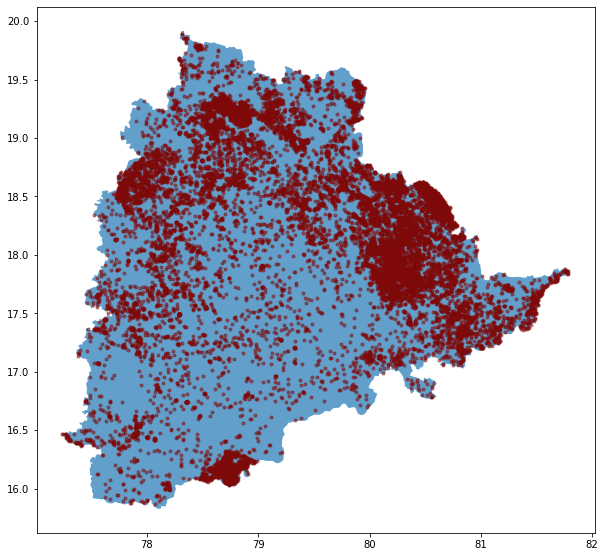

In [122]:
ax = telangana_shp.plot(figsize=(10,10),alpha=0.7)
plt.plot(telangana_fires['longitude'],
         telangana_fires['latitude'],
         '.',
         c='#800909',
         alpha=0.50)
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(15,15))
# telangana_points.plot

In [67]:
# ya no se usa aqui
# kmeans = KMeans(n_clusters=2,random_state=0).fit(df_fires[['latitude','confidence','brightness','bright_t31','frp','month']])
# labels = kmeans.labels_

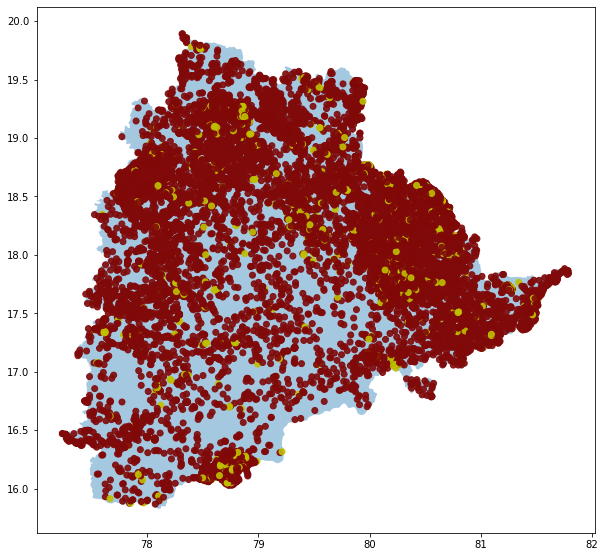

In [76]:
# # Posible a borrar ya que estara abajo

# telangana_fires['k_labels'] = labels

# # fire red color: #800909
# colors = {0:'#800909',1:'y'}


# #adding the shp
# ax = telangana_shp.plot(figsize=(10,10),alpha=0.4)
# ax.scatter(telangana_fires['longitude'],
#          telangana_fires['latitude'],
#          c=telangana_fires['k_labels'].map(colors),
#          alpha=0.90)

# plt.show()

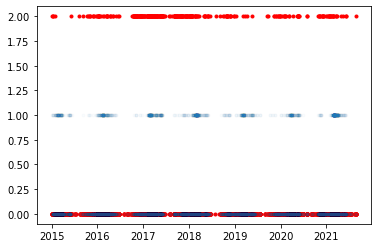

In [91]:
plt.plot(fire_type,'.r')
plt.plot(telangana_fires.k_labels,'.',alpha=0.02)

## Geemap for visualization

In [77]:
ee.Initialize()
# earthengine authenticate

In [148]:
# Possible to erase: Data has already loaded cells above
# you can try loading to see if it exists
telangana_fires

# datasets = "/home/sherwood/learning/Data4Policy/Geospatial Data Science Internship/Datasets/"


# telangana_fires = gpd.read_file(datasets + 'telangana_fires.csv')

# telangana_fires = gpd.GeoDataFrame(telangana_fires,
#                                    geometry = gpd.points_from_xy(
#                                        telangana_fires.longitude,
#                                        telangana_fires.latitude),
#                                     crs = 'EPSG:4326'
#                                    )

,fireID,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date,month,geometry
acq_date,,,,,,,,,,
2015-01-02,0,18.3777,80.5314,69,318.6,302.6,7.7,2015-01-02,1,POINT (80.53140 18.37770)
2015-01-04,1,17.5898,80.9893,59,315.4,299.5,8.8,2015-01-04,1,POINT (80.98930 17.58980)
2015-01-05,2,17.6028,81.1612,46,311.8,299.8,6.0,2015-01-05,1,POINT (81.16120 17.60280)
2015-01-05,3,17.5241,80.3135,69,317.0,302.0,9.3,2015-01-05,1,POINT (80.31350 17.52410)
2015-01-05,4,17.7571,80.3404,53,317.2,300.0,29.3,2015-01-05,1,POINT (80.34040 17.75710)
...,...,...,...,...,...,...,...,...,...,...
2021-08-24,17717,18.5503,77.7573,38,318.1,298.3,8.3,2021-08-24,8,POINT (77.75730 18.55030)
2021-08-24,17718,18.3923,77.8257,61,315.4,298.3,7.2,2021-08-24,8,POINT (77.82570 18.39230)
2021-08-24,17719,18.4943,77.7611,37,317.2,298.6,8.2,2021-08-24,8,POINT (77.76110 18.49430)


### Getting Esri LULC map

In [88]:
# Defining the map
Map = geemap.Map()

In [80]:
# Getting the path from the Telengana shapefile from GADM
telangana_path = '/mnt/c/Users/amoam/Downloads/gadm40_IND_shp/telangana_shape.shp'
telangana_shp = geemap.shp_to_ee(telangana_path)
# center = telangana_shp.centroid().getInfo()['coordinates']
# center.reverse()

In [82]:
esri_lulc10 = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m")\
                            .map( lambda image: image.clip(telangana_shp))\
                            .mean()

In [83]:
region = telangana_shp.getInfo()['features'][0]['geometry']['coordinates']

In [84]:
# Exporting the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': esri_lulc10,
    'description': 'TelanganaRaster_500',
    'folder':'Example_folder',
    'region': region,
    'scale' : 500
})
task.start()
# tasks = batch.ImageCollection.toDrive(reference, 'MyFolder', scale=5000)

In [86]:
image_viz_params = {
    "names": [
        "Water",
        "Trees",
        "Grass",
        "Flooded Vegetation",
        "Crops",
        "Scrub/Shrub",
        "Built Area",
        "Bare Ground",
        "Snow/Ice",
        "Clouds"
    ],
    "colors": [
        "#1A5BAB",
        "#358221",
        "#A7D282",
        "#87D19E",
        "#FFDB5C",
        "#EECFA8",
        "#ED022A",
        "#EDE9E4",
        "#F2FAFF",
        "#C8C8C8"
    ]
}


In [90]:
Map.addLayer(telangana_shp, {}, "Telangana")
Map.addLayer(esri_lulc10, { 'min':1, 'max':10, 'palette':image_viz_params['colors'] }, "ESRI-LULC-MAP")
Map.centerObject(telangana_shp, 7)
Map

Map(bottom=15042.0, center=[17.792484085556335, 79.05826443037053], controls=(WidgetControl(options=['position…

### Continuing 

In [149]:
# loading raster LULC map
telangana_lulc = rasterio.open('/mnt/c/Users/amoam/Downloads/TelanganaRaster_250.tif')
telangana_lulc.crs

CRS.from_epsg(4326)

In [ ]:
# # Visualización no es necesaria opr ahora, lo veré luego
# extent=[telangana_lulc.bounds[0], telangana_lulc.bounds[2], telangana_lulc.bounds[1], telangana_lulc.bounds[3]]
# fig, ax = plt.subplots()
# ax = rasterio.plot.show(telangana_lulc, ax=ax, cmap='pink')

In [150]:
# Getting data in x,y format
coord_list = [(x,y) for x,y in zip(telangana_fires['geometry'].x , telangana_fires['geometry'].y)]

In [159]:
telangana_fires['value'] = [x for x in telangana_lulc.sample(coord_list)]
telangana_fires

,fireID,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date,month,geometry,value
acq_date,,,,,,,,,,,
2015-01-02,0,18.3777,80.5314,69,318.6,302.6,7.7,2015-01-02,1,POINT (80.53140 18.37770),[5.0]
2015-01-04,1,17.5898,80.9893,59,315.4,299.5,8.8,2015-01-04,1,POINT (80.98930 17.58980),[5.0]
2015-01-05,2,17.6028,81.1612,46,311.8,299.8,6.0,2015-01-05,1,POINT (81.16120 17.60280),[5.0]
2015-01-05,3,17.5241,80.3135,69,317.0,302.0,9.3,2015-01-05,1,POINT (80.31350 17.52410),[5.0]
2015-01-05,4,17.7571,80.3404,53,317.2,300.0,29.3,2015-01-05,1,POINT (80.34040 17.75710),[5.0]
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,17717,18.5503,77.7573,38,318.1,298.3,8.3,2021-08-24,8,POINT (77.75730 18.55030),[6.0]
2021-08-24,17718,18.3923,77.8257,61,315.4,298.3,7.2,2021-08-24,8,POINT (77.82570 18.39230),[5.0]
2021-08-24,17719,18.4943,77.7611,37,317.2,298.6,8.2,2021-08-24,8,POINT (77.76110 18.49430),[5.0]


In [160]:
telangana_fires['value'] =telangana_fires['value'].astype(int)
telangana_fires
# dummy = telangana_fires[:3]
# dummy.value = dummy.value.astype(int)
# type(dummy.value[0])

,fireID,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date,month,geometry,value
acq_date,,,,,,,,,,,
2015-01-02,0,18.3777,80.5314,69,318.6,302.6,7.7,2015-01-02,1,POINT (80.53140 18.37770),5
2015-01-04,1,17.5898,80.9893,59,315.4,299.5,8.8,2015-01-04,1,POINT (80.98930 17.58980),5
2015-01-05,2,17.6028,81.1612,46,311.8,299.8,6.0,2015-01-05,1,POINT (81.16120 17.60280),5
2015-01-05,3,17.5241,80.3135,69,317.0,302.0,9.3,2015-01-05,1,POINT (80.31350 17.52410),5
2015-01-05,4,17.7571,80.3404,53,317.2,300.0,29.3,2015-01-05,1,POINT (80.34040 17.75710),5
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,17717,18.5503,77.7573,38,318.1,298.3,8.3,2021-08-24,8,POINT (77.75730 18.55030),6
2021-08-24,17718,18.3923,77.8257,61,315.4,298.3,7.2,2021-08-24,8,POINT (77.82570 18.39230),5
2021-08-24,17719,18.4943,77.7611,37,317.2,298.6,8.2,2021-08-24,8,POINT (77.76110 18.49430),5


In [161]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(telangana_fires[['latitude','confidence','brightness','bright_t31','frp','month','value']])
labels = kmeans.labels_

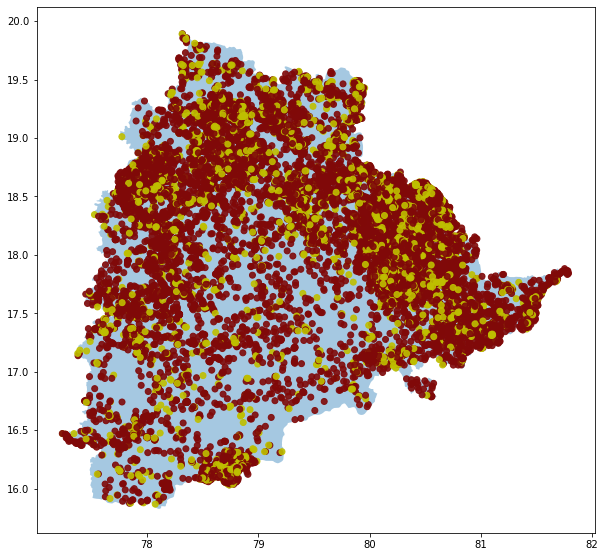

In [180]:
telangana_fires['k_labels'] = labels

# fire red color: #800909
colors = {1:'#800909',0:'y'}


#adding the shp
ax = telangana_shp.plot(figsize=(10,10),alpha=0.4)
ax.scatter(telangana_fires['longitude'],
         telangana_fires['latitude'],
         c=telangana_fires['k_labels'].map(colors),
         alpha=0.90)

plt.show()

In [179]:
# Viewing results from clustering

telangana_fires.groupby('k_labels').count()

,fireID,latitude,longitude,confidence,brightness,bright_t31,frp,acq_date,month,geometry,value
k_labels,,,,,,,,,,,
0,4281,4281,4281,4281,4281,4281,4281,4281,4281,4281,4281
1,13441,13441,13441,13441,13441,13441,13441,13441,13441,13441,13441


In [177]:
# Viewing original labels

fire_types.groupby('type').count()

,confidence
type,
0,17370
2,352
